Ningbo University of Technology - Computer Vision 

姓名：李家东

学号：20401240118

班级：AI201

日期：2023/5/20

# 实验3: 图像分割

## 任务 1: 基于边缘检测的图像分割  [30分]

### a) 梯度 [5分]
什么是图像的梯度？如何计算图像的一阶和二阶导数？

你的回答：</p>
图像的梯度是指图像中像素值变化最快的方向和变化率。</p>
计算图像的一阶导数可以使用Sobel算子、Prewitt算子、Roberts算子等算子，这些算子可以通过卷积运算来计算图像在x和y方向上的梯度。</p>
计算图像的二阶导数可以使用img算子，它可以通过以下卷积核来计算图像的二阶导数。

### b) 边缘连接 [5分]

请用你自己的语言描述边缘连接的概念。它的目标是什么？

你的回答：</p>
边缘连接是一种图像处理技术，它的目标是将图像中的边缘连接成为连续的线条或曲线。在图像处理中，边缘是指图像中像素值变化较大的区域，通常表示图像中不同物体或区域之间的分界线。边缘连接的目的是将这些边缘连接成为连续的线条或曲线，从而更好地描述图像中的物体形状和结构。


### c) 零交叉（Zero crossings）[5分]

请解释零交叉是什么？为什么检测零交叉总是会产生闭合轮廓？

你的回答：</p>
零交叉是指在图像中，像素值从正数变为负数或从负数变为正数的位置。在边缘检测中，零交叉通常用于检测图像中的边缘，因为边缘通常是图像中像素值变化较大的区域，而零交叉正好标志着这种变化。</p>
在边缘检测中，检测到的零交叉通常会被连接成为闭合轮廓。这是因为边缘通常是物体的分界线，而物体通常是封闭的，因此边缘也应该是封闭的。当检测到一个零交叉时，它通常表示着一个边缘的起点或终点，而这个边缘应该是封闭的，因此需要在图像中寻找与之相连的其他零交叉，从而将它们连接成为一个闭合轮廓。

### d) 零交叉实现 [15分]

给出零交叉的实现。

提示：为获得合理的结果，在应用拉普拉斯滤波器之前，应该对图像进行平滑处理，例如使用高斯拉普拉斯。

d:\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


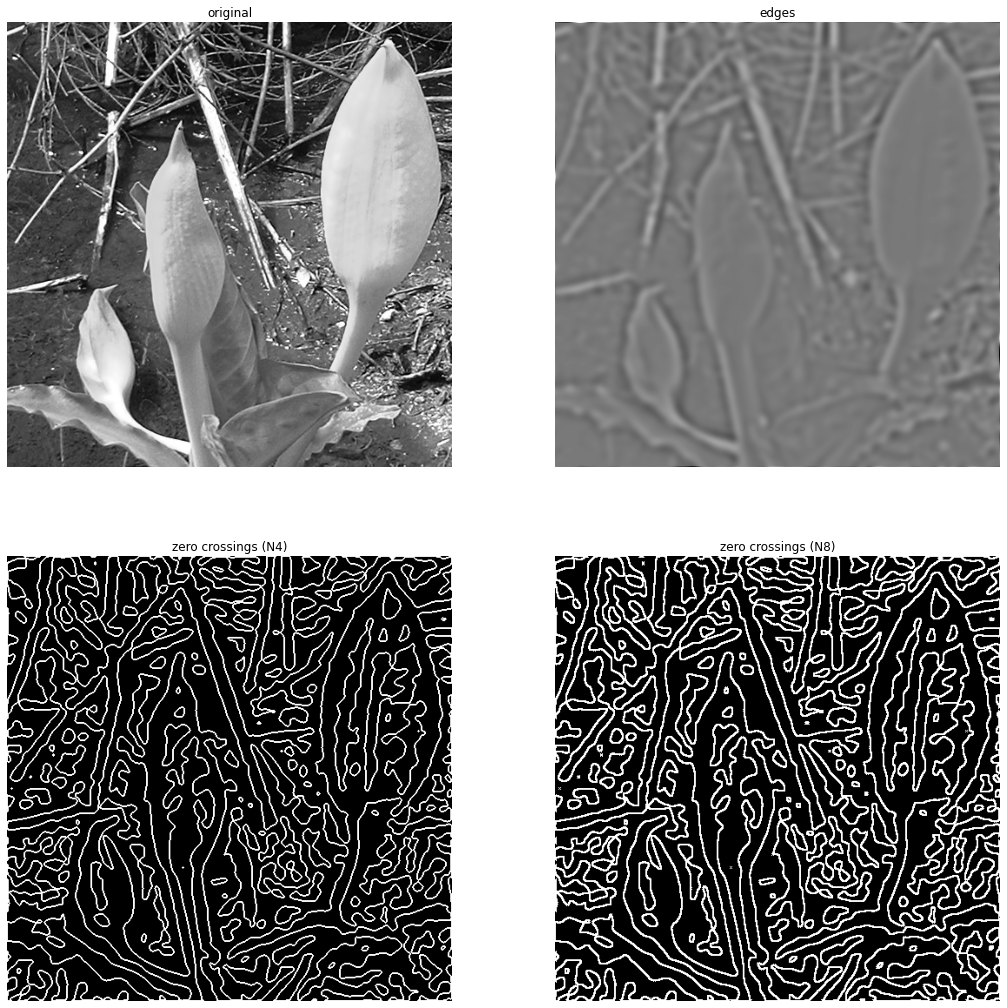

In [24]:
from skimage import filters
from imageio import imread
import matplotlib.pyplot as plt
from scipy.ndimage import shift
import numpy as np
%matplotlib inline

img = imread('pictures/swampflower.png').astype(float)
img /= img.max()

# Now compute edges and then zero crossings using the 4-neighborhood and the 8-neighborhood
# YOUR CODE HERE
# 对图像进行平滑处理，使用高斯拉普拉斯滤波器进行边缘检测
edges = filters.gaussian(img, sigma=5)
edges = filters.laplace(edges)

shifted_img = shift(edges, (1, 0), cval=0)
edges_4 = np.logical_xor(edges > 0, shifted_img > 0)

shifted_img = shift(edges, (-1, 0), cval=0)
edges_4 = np.logical_or(edges_4, np.logical_xor(edges > 0, shifted_img > 0))

shifted_img = shift(edges, (0, 1), cval=0)
edges_4 = np.logical_or(edges_4, np.logical_xor(edges > 0, shifted_img > 0))

shifted_img = shift(edges, (0, -1), cval=0)
edges_4 = np.logical_or(edges_4, np.logical_xor(edges > 0, shifted_img > 0))

shifted_img = shift(edges, (1, 1), cval=0)
edges_8 = np.logical_xor(edges > 0, shifted_img > 0)

shifted_img = shift(edges, (-1, 1), cval=0)
edges_8 = np.logical_or(edges_8, np.logical_xor(edges > 0, shifted_img > 0))

shifted_img = shift(edges, (1, -1), cval=0)
edges_8 = np.logical_or(edges_8, np.logical_xor(edges > 0, shifted_img > 0))

shifted_img = shift(edges, (-1, -1), cval=0)
edges_8 = np.logical_or(edges_8, np.logical_xor(edges > 0, shifted_img > 0))

# 显示结果
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))
ax = axes.ravel()
ax[0].imshow(img, cmap='gray')
ax[0].set_title('original')
ax[0].axis('off')
ax[1].imshow(edges, cmap='gray')
ax[1].set_title('edges')
ax[1].axis('off')
ax[2].imshow(edges_4, cmap='gray')
ax[2].set_title('zero crossings (N4)')
ax[2].axis('off')
ax[3].imshow(edges_8, cmap='gray')
ax[3].set_title('zero crossings (N8)')
ax[3].axis('off')
plt.show()




## 任务 2: Watershed transform  [40分]



### a) 分水岭变换 [5分]

请用你自己的语言解释分水岭变换的概念。为什么分水岭变换总是会给出一个闭合轮廓？

你的回答：</p>
- 分水岭变换的概念

分水岭变换是一种图像分割算法，它将图像中的每个像素都看作是一个地形上的高度，然后通过寻找水从哪里流下来，将图像分成不同区域。在分水岭变换中，图像中的每个像素都被赋予一个高度值，这些高度值可以表示为灰值或梯度值。然后，算法会从这些高度值中找到局部最小值，这些最小值被称为分水岭。接下来，算法会从每个分水岭开始，将其周围的像素标记为该分水岭的一部分，直到所有像素都被标记为某个分水岭的一部分。

- 为什么分水岭变换总是会给出一个闭合轮廓

因为算法会从每个分水岭开始，将其周围的像素标记为该分水岭的一部分，直到所有像素都被标记为某个分水岭的一部分。这样，每个分水岭都会被标记为一个封闭的区域，因此最终的结果也是封闭的轮廓。

### b) 实现 [20分]

使用洪水填充方法（flooding approach）实现分水岭变换。

d:\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


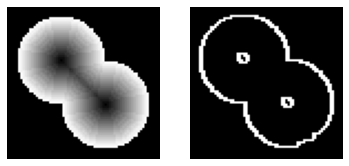

In [89]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

def watershed(img, step=1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img (ndarray): The grayscale image.
        step (int): The rise of the water level at each step. Default 1.
        
    Returns:
        edges (ndarray): A binary image containing the watersheds.
    """
    NO_LABEL = 0
    WATERSHED = 1
    new_label = 2

    # Initialize labels
    label = np.zeros(img.shape, np.uint16)

    # Initialize the queue with all the regional minima as seeds
    queue = []
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            neighbors = get_neighbor_labels(label, i, j)
            if img[i][j] <= np.min(neighbors) + 1:
                label[i][j] = new_label
                queue.append((i, j))

    while len(queue) > 0:
        x, y = queue.pop(0)
        neighbors = get_neighbor_labels(label, x, y)

        if np.any(np.array(neighbors) == WATERSHED):
            label[x][y] = WATERSHED
        else:
            label[x][y] = WATERSHED

            for dx in range(-1, 2):
                for dy in range(-1, 2):
                    nx, ny = x + dx, y + dy
                    if (dx == 0 and dy == 0) or nx < 0 or ny < 0 or nx >= img.shape[0] or ny >= img.shape[1]:
                        continue
                    if label[nx][ny] == NO_LABEL:
                        label[nx][ny] = new_label
                        queue.append((nx, ny))

    for i in range(3, img.shape[0] - 3):
        for j in range(3, img.shape[1] - 3):
            if i - 1 < 0 or j - 1 < 0 or i + 1 >= img.shape[0] or j + 1 >= img.shape[1]:
                continue
            neighbors = get_neighbor_labels(label, i, j)
            if np.any(np.array(neighbors) == WATERSHED) and np.any(np.array(neighbors) == NO_LABEL):
                label[i][j] = new_label

    edges = (label == new_label).astype(np.uint8)
    return edges

def get_neighbor_labels(label, x, y):
    return [
        label[x - 1, y - 1], label[x, y - 1], label[x + 1, y - 1], label[x - 1, y],
        label[x + 1, y], label[x - 1, y + 1], label[x, y + 1], label[x + 1, y + 1]
    ]

image_path = 'pictures/dist_circles.png'
image = imageio.imread(image_path, pilmode='L')

plt.gray()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(watershed(image))
plt.show()


### c) 应用: 迷宫 [15分]

使用分水岭变换来找到迷宫的出路。为此，首先对迷宫应用距离变换，然后对结果进行洪水填充。分水岭将向展示穿过迷宫的路线。

d:\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # Remove the CWD from sys.path while we load stuff.


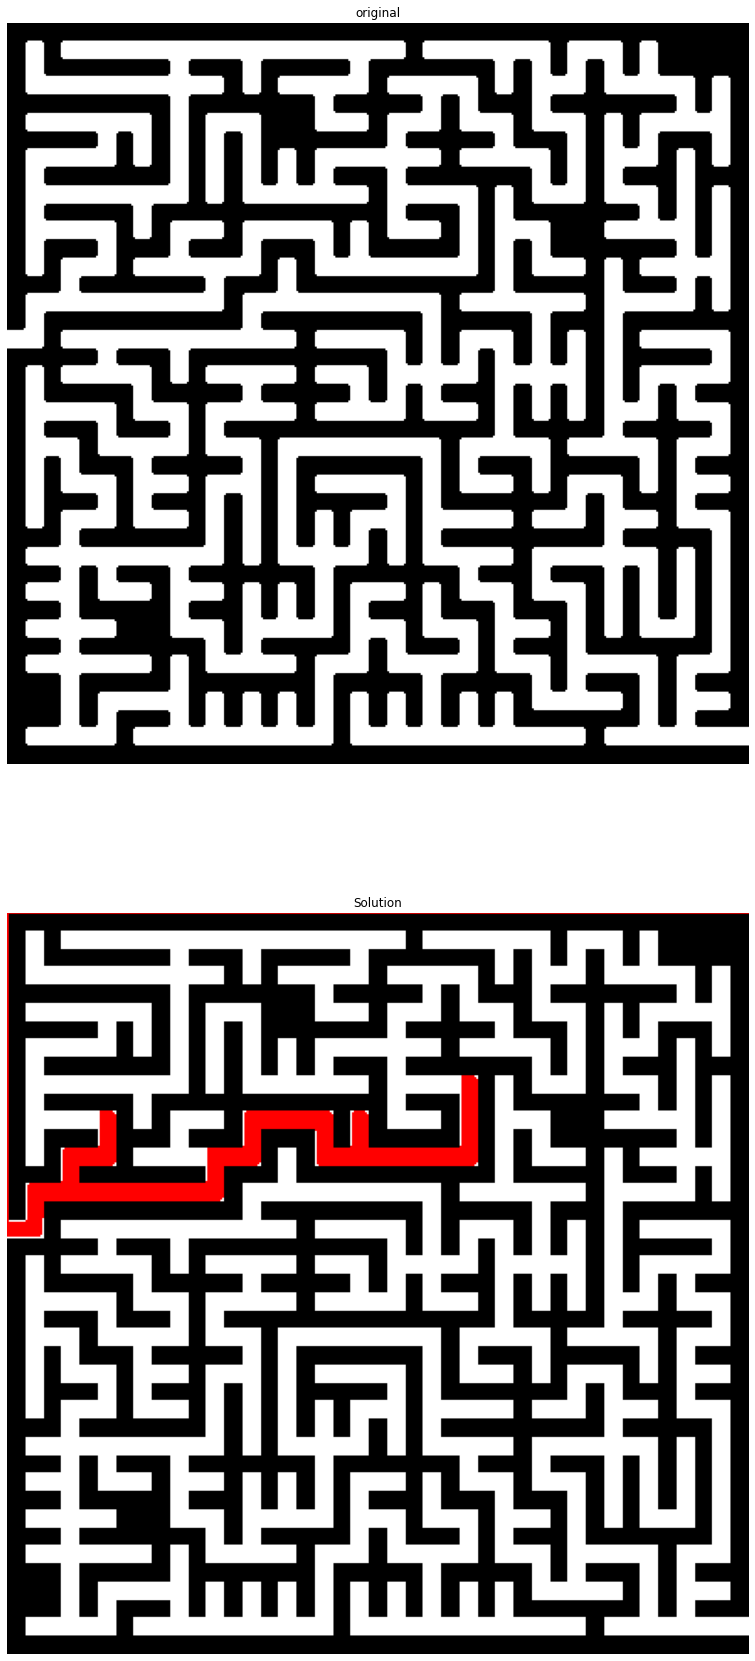

In [84]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import watershed
%matplotlib inline

img = imageio.imread('pictures/maze.png', pilmode = 'L') 

result = img[:, :, np.newaxis].repeat(3, 2)

# YOUR CODE HERE
# 应用距离变换
dist_transform = distance_transform_edt(img)

# 应用洪水填充
markers = np.zeros_like(img)
markers[img == 0] = 1 # Set the markers at the maze walls
markers[img == 255] = 2 # Set the markers at the maze paths
labels = watershed(-dist_transform, markers, mask=img)

# result = np.zeros_like(img, dtype=np.uint8)
result[labels == 1] = 225 # Color the walls as white
result[labels == 2] = 127 # Color the paths as gray

path = np.zeros_like(img, dtype=np.uint8)
path[labels == 2] = 255 # Color the path as white

# 显示结果
# Display the result
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,30))
ax = axes.ravel()
ax[0].imshow(img, cmap='gray')
ax[0].set_title('original')
ax[0].axis('off')
ax[1].imshow(path, cmap='gray')
ax[1].set_title('Solution')
ax[1].axis('off')
plt.show()


The solution path is the watershed between the catchment basins.

## 任务 3: $k$-均值分割 [30分]


**a)** 请解释k均值聚类的概念，并陈述如何将其用于图像分割。 [5分]

你的回答：</p>
- K均值聚类概念

K均值聚类是一种无监督学习算法，用于将数据集分成K个不同的类别。该算法将数据点分配到最的聚类中心，然后更新聚类中心以最小化聚类内部的平方误差和。这个过程重复进行，直聚类中心不再改变或达到预定的迭代次数。

- 应用图像分割

在图像分割中，我们可以使用K均值聚类来将图像分成K个不同的区域。具体来说，我们可以将图像中的每个像素看作是一个数据点，并使用K均值聚类算法将这些像素分配到K个不同的聚类中心。然后，我们可以将每个聚类中的像素标记为该聚类的颜色，从而实现图像分割。

**b)** 对一个RGB图像实现基于k均值聚类的颜色分割。 [15分]

提示：当中心向量的变化量小于预定义的阈值时停止计算。通过重新初始化相应的中心向量来避免空聚类。

首先，看一下图像在RGB颜色空间中的样子:

d:\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


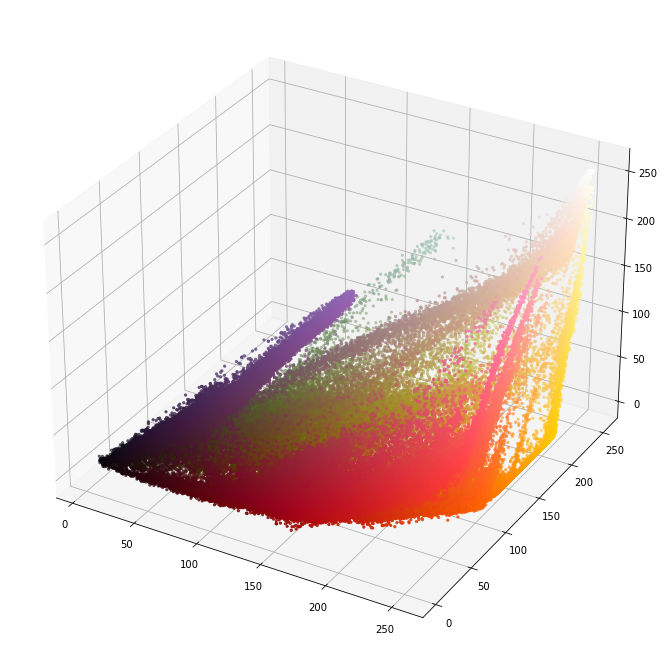

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline

img = imread('pictures/peppers.png')
vec = img.reshape((-1, img.shape[2]))
vec_scaled = vec / 255
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ret = ax.scatter(vec[:, 0], vec[:, 1], vec[:, 2], c=vec_scaled, marker='.')

其次，给出在RGB颜色空间进行$k$-均值分割的代码:

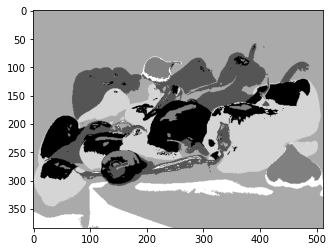

7.551208023540188


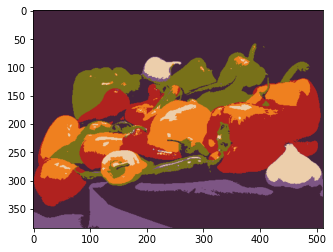

In [91]:
import numpy as np
from scipy.spatial import distance
from IPython import display
from imageio import imread
import time
import matplotlib.pyplot as plt
%matplotlib inline


def kmeans_rgb(img, k, threshold=0, do_display=None):
    """
    k-means clustering in RGB space.

    Args:
        img (numpy.ndarray): an RGB image
        k (int): the number of clusters
        threshold (float): Maximal change for convergence criterion.
        do_display (bool): Whether or not to plot, intermediate steps.
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): 'number of clusters' x 3 array. 
            RGB color for each cluster center.
    """

    # initialize random cluster centers (k random rgb tuples)
    centers = np.array([np.random.randint(255, size=3) for _ in range(k)])
    # list of rgb values in img
    rgb_list = [[img[x][y][0], img[x][y][1], img[x][y][2]] for x in range(img.shape[0]) for y in range(img.shape[1])]

    change = np.inf

    while change > threshold:
        change = 0
        # compute distance between each pair of the two collections of inputs
        rgb_dist_to_centers = distance.cdist(rgb_list, centers)
        # assign closest cluster center to each rgb value
        cluster_for_each_rgb = np.array([np.argmin(distances) for distances in rgb_dist_to_centers])
        
        # YOUR CODE HERE
        # update cluster centers
        for i in range(k):
            # get all RGB values assigned to this cluster
            cluster_rgb_values = np.array([rgb_list[j] for j in range(len(rgb_list)) if cluster_for_each_rgb[j] == i])
            # if there are no RGB values assigned to this cluster, skip it
            if len(cluster_rgb_values) == 0:
                continue
            # compute the mean RGB value for this cluster
            new_center = np.mean(cluster_rgb_values, axis=0)
            # compute the change in this cluster center
            center_change = np.linalg.norm(new_center - centers[i])
            # update the cluster center
            centers[i] = new_center
            # update the total change
            change += center_change
        
        # display intermediate results
        if do_display:
            display.clear_output(wait=True)
            plt.imshow(cluster_for_each_rgb.reshape((img.shape[0], img.shape[1])))
            plt.show()
            time.sleep(0.5)

        print(change)

    return cluster_for_each_rgb.reshape((img.shape[0], img.shape[1])), centers

img = imread('pictures/peppers.png')

cluster, centers = kmeans_rgb(img, k=7, threshold=8, do_display=True)
plt.imshow(centers[cluster])
plt.show()

**c)** 在HSV颜色空间进行$k$-均值分割  [10分]

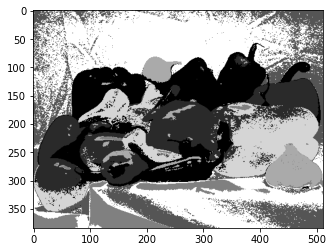

0.008433975325568973


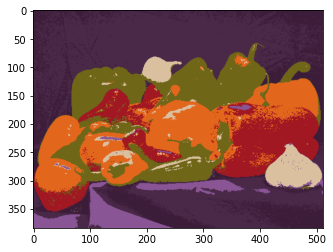

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import color
from imageio import imread
%matplotlib inline

img = imread('pictures/peppers.png', pilmode = 'RGB')

def kmeans_hsv(img, k, threshold = 0, do_display=None):
    """
    k-means clustering in HSV space.

    Args:
        img (numpy.ndarray): an HSV image
        k (int): the number of clusters
        threshold (float): 
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """
    
    # initialize random cluster centers (k random hsv tuples)
    centers = np.array([np.random.uniform(0, 1, size=3) for _ in range(k)])
    # list of rgb values in img
    hsv_list = [[img[x][y][0], img[x][y][1], img[x][y][2]] for x in range(img.shape[0]) for y in range(img.shape[1])]

    change = np.inf

    while change > threshold:
        change = 0
        # compute distance between each pair of the two collections of inputs
        hsv_dist_to_centers = distance.cdist(hsv_list, centers)
        # assign closest cluster center to each hsv value
        cluster_for_each_hsv = np.array([np.argmin(distances) for distances in hsv_dist_to_centers])
        
        # YOUR CODE HERE
        # update cluster centers
        for i in range(k):
            # get all HSV values assigned to this cluster
            cluster_hsv_values = np.array([hsv_list[j] for j in range(len(hsv_list)) if cluster_for_each_hsv[j] == i])
            # if there are no HSV values assigned to this cluster, skip it
            if len(cluster_hsv_values) == 0:
                continue
            # compute the mean HSV value for this cluster
            new_center = np.mean(cluster_hsv_values, axis=0)
            # compute the change in this cluster center
            center_change = np.linalg.norm(new_center - centers[i])
            # update the cluster center
            centers[i] = new_center
            # update the total change
            change += center_change
        
        # display intermediate results
        if do_display:
            display.clear_output(wait=True)
            plt.imshow(cluster_for_each_hsv.reshape((img.shape[0], img.shape[1])))
            plt.show()
            time.sleep(0.5)
        
        print(change)

    return cluster_for_each_hsv.reshape((img.shape[0], img.shape[1])), centers


img_hsv = color.rgb2hsv(img)
k = 7
theta = 0.01

cluster, centers_hsv = kmeans_hsv(img_hsv[:,:,:], k, theta, do_display=True)
if (centers_hsv.shape[1] == 3):
    plt.imshow(color.hsv2rgb(centers_hsv[cluster]))
else:
    plt.gray()
    plt.imshow(np.squeeze(centers_hsv[cluster]))
plt.show()
